In [1]:
#importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D, \
BatchNormalization, SpatialDropout1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from imblearn.combine import SMOTETomek
import warnings
#Surpressing all deprecation and future warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
#Sets the global random tf seed
tf.random.set_random_seed(42)

Using TensorFlow backend.


In [ ]:
#mounting the drive to this notebook
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [3]:
#loading the dataset
raw = np.load('/content/drive/My Drive/data/Data_Raw_signals.pkl', allow_pickle=True)

In [4]:
#Splitting our features and targets
feat = raw[0]
targets = raw[1]

In [8]:
#Checking for missing data in the dataset - no NAs
print(np.isnan(feat).sum())

0


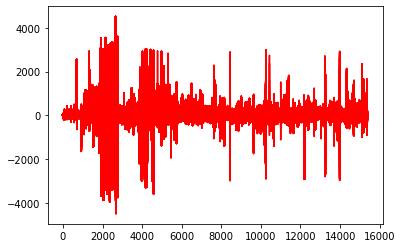

In [29]:
#vizualizing the signals
signal = feat.reshape(feat.shape[0], feat.shape[1] * feat.shape[2])
plt.plot(signal, 'r')
plt.show()

In [0]:
#Reshaping the features to convert them to 2D, to feed it into SMOETomek 
feat_X = np.reshape(feat, (feat.shape[0], feat.shape[1] * feat.shape[2]))

In [0]:
#OverSampling the data using SMOTETomek, since we have an imbalanced dataset
smk = SMOTETomek(random_state=42)
feat_X, targets_Y = smk.fit_resample(feat_X, targets)

In [12]:
#Shape and dimensions of the dataset after the transformation
print(f"Initial Shape: {feat_X.shape} \nDimensions: {feat_X.ndim}")

#Reshaping it to get to the desired shape of samples, timesteps, features
feat_x = feat_X.reshape(feat_X.shape[0], feat.shape[2], feat.shape[1])
print('Final shape:',feat_x.shape)

Initial Shape: (15375, 6000) 
Dimensions: 2
Final shape: (15375, 3000, 2)


In [0]:
#Setting the X and y and subsequently splitting the data
X = feat_x
y = targets_Y

#test size of 10% with random_state of 62, stratifying and shuffling the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, shuffle=True,
                                                    stratify=y, random_state=62)

In [14]:
#Encoding the labels
lbl = LabelEncoder()
y_train = lbl.fit_transform(y_train)
y_test = lbl.transform(y_test)

#We have 6 labels
print(np.unique(y_test), f'\nNumber of labels: {len(np.unique(y_test))}')

[0 1 2 3 4 5] 
Number of labels: 6


In [15]:
#Original shape of our train and test set
print("X_train shape:",X_train.shape, "\nX_test shape:",X_test.shape)

X_train shape: (13837, 3000, 2) 
X_test shape: (1538, 3000, 2)


In [0]:
#encoding the test_data to 0s and 1s
labels = 6

y_test_cat = to_categorical(y_test, labels)
y_train_cat = to_categorical(y_train, labels)

In [17]:
#New shape
print("y_train_cat shape:",y_train_cat.shape)
print("y_test_cat shape:",y_test_cat.shape)

y_train_cat shape: (13837, 6)
y_test_cat shape: (1538, 6)


In [0]:
#defining checkpoint and the early stopping to prevent overfitting
checkpoint = ModelCheckpoint(filepath='bestmodel.hdf5', monitor='val_loss', 
                             save_weights_only=True,  mode='min', save_best_only=True, verbose=1)
Early_Stopping = EarlyStopping(monitor='val_loss', patience=15, mode='min', restore_best_weights=True)

In [0]:
#Defining callbacks and our validation set
callbacks = [Early_Stopping, checkpoint]
validation = [X_test, y_test_cat]

In [20]:
#input shape to feed to our CNN
final_shape = X_train[0].shape
print(final_shape)

(3000, 2)


In [0]:
#Conv1D Model
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=(60), strides=2, padding='same',
                 activation='relu', input_shape=(final_shape)))
model.add(MaxPooling1D(12))
model.add(BatchNormalization())
model.add(SpatialDropout1D(rate=0.2))

model.add(Conv1D(filters=108, kernel_size=(60), strides=2, activation='relu', padding='same'))
model.add(MaxPooling1D(9))
model.add(BatchNormalization())
model.add(SpatialDropout1D(rate=0.2))

model.add(Conv1D(filters=86, kernel_size=(60), strides=2, padding='same', activation='relu'))
model.add(MaxPooling1D(4))
model.add(BatchNormalization())
model.add(SpatialDropout1D(rate=0.2))
model.add(Flatten())

model.add(Dense(68, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(6, activation='softmax'))

opt='adagrad'
#Compiling the model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train_cat, epochs=100, batch_size=1054, verbose=1, 
                        validation_data=validation, callbacks=callbacks)

In [0]:
#plotting the model diagram
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [0]:
#Load the best weights
model.load_weights('bestmodel.hdf5')

In [ ]:
#Conv1D -> calcuting validation accuracy and loss
val_loss, val_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print('Validation loss:',val_loss, '\nValidation accuracy:',val_acc)

In [0]:
#overview of the model
model.summary()

In [0]:
y_pred = model.predict_classes(X_test, labels)
y_pred = to_categorical(y_pred, labels)

In [0]:
#Classification report
print(classification_report(y_test_cat, y_pred))

In [0]:
#As above, showing the results of precision, recall and f1-score
print("Precision:", round(precision_score(y_test_cat, y_pred, average = 'macro') * 100, 2))
print("Recall:   ", round(recall_score(y_test_cat, y_pred, average = 'macro') * 100, 2))
print("f1-score: ", round(f1_score(y_test_cat, y_pred, average = 'macro') * 100, 2))

In [0]:
#checking the keys of the dictionary
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [0]:
#setting the names before plotting
accuracy = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
#Plotting train vs validation accuracy
plt.plot(accuracy,'r')
plt.plot(val_acc, 'b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

In [ ]:
#Plotting train vs validation loss
plt.plot(loss, 'r')
plt.plot(val_loss, 'b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

In [0]:
#Loading the test set
test = np.load('/content/drive/My Drive/data/Test_Raw_signals_no_labels.pkl', allow_pickle=True)

In [0]:
test_data = test[0]
test_data.shape

(1754, 2, 3000)

In [0]:
#Saving the shape of the test set to be later used when reshaping it
X_t_shape = test_data.shape

In [0]:
X_t_shape

(1754, 2, 3000)

In [0]:
#Reshaping the test data
test_data_tf = test_data.reshape(X_t_shape[0], X_t_shape[2], X_t_shape[1])

In [0]:
y_t = model.predict_classes(test_data_tf)

In [0]:
y_test_decoded = lbl.inverse_transform(y_t)

In [0]:
#Save the text with the predicted labels
np.savetxt('answer.txt', y_test_decoded, delimiter=',', fmt='%d')